# <Center>Relationship between Housing prices & maturity index of different postal districts in Helsinki  
## <center>Capstone Project - The Battle of the Neighborhoods (Week 2)

## 1. Introduction

### 1.1 Description of the problem & Discussion of the background

Helsinki is the capital city of Finland. Located on the shore of the Gulf of Finland. Together with the cities of Espoo, Vantaa, and Kauniainen, and surrounding commuter towns, Helsinki forms the Greater Helsinki metropolitan area, which has a population of nearly 1.5 million. The region’s land area accounts for 1.2% of the area of the entire country, but it accommodates 27% of the Finnish population. 

Helsinki metropolitan area is the dominant region in the Finnish property market. The area is well recognised among foreign investors, and many large global players only invest in the capital region. Positive supply developments have, in turn, bolstered housing investment while at the same time mitigating price growth significantly. 

In this project, we are aiming to analyse the relationship between the housing price & maturity index of various postal districts in Helsinki. 


### 1.2 description of the data and how it will be used to solve the problem

To solve the above problem, we first need to define maturity index. As residents enjoy various amenities that have been developed over the years, which include transport networks, shopping malls, schools, and parks. We can use the diversity and abundance of the district to indicate the maturity index.

Foursquare defines a three-level hierarchical structure of categories for venues. With nine top level categories: Arts & Entertainment, College & University, Food, Professional & Other Places, Nightlife Spot, Outdoors & Recreation, Shop & Service, Travel & Transport and Residence. 

Here is the thought: we can use **Foursquare** to get the information of different categories or venue one district has, to stand for its diversity and abundance of the district, in another word, the maturity index. 

Then using **Machine Learning** method to analyse the relationship between housing price & maturity index of various postal districts in Helsinki.

## 2. Data

Giving the problems, we list the data that will be used as below:

- The “Statistical yearbook of Helsinki 2019”, which includes the average housing sale price of 2018 for various postal districts in Helsinki, has been collected from  [Helsinki Region infoshare](https://hri.fi/data/en_GB/dataset/helsingin-tilastollinen-vuosikirja). The .xlsx table file has been downloaded. Data has been cleaned and reduced. We will used this data later to analyse.

- Geocoder Python package will be used to obtain the coordinates of different postal code area of Helsinki.

- Helsinki districts boundaries by postal code .geojson file is obtained from [Helsinki City Survey Division](https://kartta.hel.fi/?setlanguage=en&e=25496825&n=6673044&r=3.99&w=&l=Karttasarja&o=100#). This will be used to show the districts map of Helsinki.

- Forsquare API will be used to get the number of different venues of given districts of Helsinki.


### 2.1 import the file of housing price in Helsinki of 2018

Read the data from file **"Housing_Price_in_Helsinki_2018.xlsx"**, There are total 84 different postal code for Helsinki region. Thus, check the type, should be **84 x 3**. Three columns are "Postal Code", "District Name" and "Housing price (euro/m2)"

In [ ]:
!pip install pgeocode

In [ ]:
!conda install -c conda-forge folium=0.5.0 --yes

In [ ]:
!conda install -c conda-forge geopy --yes

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import folium
import numpy as np
import pandas as pd
import pgeocode
import json
import requests
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize

In [50]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split  
from scipy.optimize import curve_fit

In [123]:
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score

In [43]:
path = r'C:\Users\yun\Desktop\Coursera\Course 9_Applied Data Science Capstone\Housing_Price_in_Helsinki_2018.xlsx'
df = pd.read_excel(path, converters = {u'Postal Code':str, u'Housing price (euro/m2)':float})
df.head(10)

,Postal Code,District Name,Housing price (euro/m2)
0,00100,Helsinki Keskusta - Etu-Töölö,7038.0
1,00120,Punavuori,7526.0
2,00130,Kaartinkaupunki,7938.0
3,00140,Kaivopuisto - Ullanlinna,7945.0
4,00150,Eira - Hernesaari,7663.0
5,00160,Katajanokka,6443.0
6,00170,Kruununhaka,7017.0
7,00180,Kamppi - Ruoholahti,7354.0
8,00190,Suomenlinna,0.0
9,00200,Lauttasaari,5911.0


From above, we can see there are some **0.0 values for housing price**, which means there are no sales in that areas due to different reasons. we still keep the values here to a better visulization later. 

Now, let's check the type of the different columns

In [5]:
df.dtypes

Postal Code                 object
District Name               object
Housing price (euro/m2)    float64
dtype: object

Let's check the shape of the dataset

In [6]:
df.shape

(84, 3)

Dataset is 84 x 3, matches the original data. Thus, the housing price file has been read successfully and corretly. 

Next, we will add **coordinates of different districts** via Geocoder Python package to the dataset

### 2.2 Import Helsinki .geojson file 

In [7]:
# let's get Helsinki latitude and longitude values, and have a look of Helsinki map

address = "Helsinki,FI"

geolocator = Nominatim(user_agent="ny_explorer")
hel_location = geolocator.geocode(address)
hel_latitude = hel_location.latitude
hel_longitude = hel_location.longitude
print('The geograpical coordinate of Helsinki City are {}, {}.'.format(hel_latitude, hel_longitude))

helsinki_map = folium.Map(location=[hel_latitude, hel_longitude], zoom_start=12, tiles = 'Stamen Terrain')

helsinki_map.add_child(folium.LatLngPopup())
helsinki_map

The geograpical coordinate of Helsinki City are 60.1674098, 24.9425769.


In [8]:
# Next, let's load the data
geo_path = r'C:\Users\yun\Desktop\Helsinki_geo.json'
with open(geo_path) as f:
    hel_border = json.load(f)

# Let's take a quick look at the data.
hel_border

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'geometry': {'type': 'Polygon',
    'coordinates': [[[25492544.7853813, 6680222.83523133],
      [25492467.3704098, 6680216.56386137],
      [25492417.8290768, 6680207.25382598],
      [25492360.2588927, 6680192.60083224],
      [25492318.5483551, 6680180.56966169],
      [25492588.9499165, 6679861.87040625],
      [25492961.6797554, 6679412.81472883],
      [25493195.6062728, 6679135.44223023],
      [25493246.3899145, 6679067.12272644],
      [25493271.7573206, 6679016.21712078],
      [25493294.3187134, 6678960.07357919],
      [25493695.7262764, 6679005.8520939],
      [25493631.7294206, 6679378.44652081],
      [25493680.5551381, 6679454.82189598],
      [25493731.911984, 6679549.92330929],
      [25493717.9851908, 6679709.32443501],
      [25493718.1415795, 6679746.82288316],
      [25493708.2235193, 6679793.78399073],
      [25493717.0054675, 6679827.32590843],
      [25493721.5641876, 6679844.7543589],
      [25

In [9]:
# Our key would be the postal code, so we need to find where is the postal code in this .json file and also it's order
df_geo = pd.read_json(geo_path)
df_geo['features'][0]['properties']['tunnus']

'00440'

In [10]:
# let's using the loop to get the order of json file. So we can use this order to sort our df dataset.
number = len(df_geo)
zip_list =[]
id_list = []

for i in range (number):
    zip_list.append(df_geo['features'][i]['properties']['tunnus'])
    id_list.append(df_geo['features'][i]['properties']['id'])

In [11]:
# let's sort our df dataset according to zip_list from above
df['Postal Code'] = df['Postal Code'].astype('category')

df['Postal Code'].cat.reorder_categories(zip_list, inplace=True)

df.sort_values('Postal Code', inplace=True)
df = df.reset_index(drop=True)
df['id'] = id_list
df.head()

,Postal Code,District Name,Housing price (euro/m2),id
0,00440,Lassila,3720.0,111475
1,00560,Toukola-Vanhakaupunki,5328.0,114541
2,00670,Paloheinä,3674.0,111452
3,00280,Ruskeasuo,5561.0,111453
4,00310,Kivihaka,4392.0,111454


Now we have changed our df dataset to the order that matches the json file postal code order. 

### 2.3 Calculate and add the coordinates of different districts in Helsinki to the dataset

In [12]:
# covert the values in df['Postal Code'] to list. So we can use the list to get the coordinates later.
zip_list = df['Postal Code'].values.tolist()

nomi = pgeocode.Nominatim('fi')

# get coordinates of different district via Geocoder Python Package. and store the dataframe to "df_coor"
df_coor = nomi.query_postal_code(zip_list)

# show the first 5 rows of df_coor
df_coor.head()

,postal_code,country code,place_name,state_name,state_code,county_name,county_code,community_name,community_code,latitude,longitude,accuracy
0,00440,FI,Helsinki,Uusimaa,1,Helsinki,11,Helsinki,91,60.2313,24.8796,6.0
1,00560,FI,Helsinki,Uusimaa,1,Helsinki,11,Helsinki,91,60.2100,24.9726,6.0
2,00670,FI,Helsinki,Uusimaa,1,Helsinki,11,Helsinki,91,60.2516,24.9326,6.0
3,00280,FI,Helsinki,Uusimaa,1,Helsinki,11,Helsinki,91,60.2019,24.9043,6.0
4,00310,FI,Helsinki,Uusimaa,1,Helsinki,11,Helsinki,91,60.2106,24.9035,6.0


In [13]:
# add the values of latitude and longitude to df dataset
df['latitude'] = df_coor['latitude']
df['longitude'] = df_coor['longitude']

# let's check if coordinates have been added correctly.
df.head()

,Postal Code,District Name,Housing price (euro/m2),id,latitude,longitude
0,00440,Lassila,3720.0,111475,60.2313,24.8796
1,00560,Toukola-Vanhakaupunki,5328.0,114541,60.2100,24.9726
2,00670,Paloheinä,3674.0,111452,60.2516,24.9326
3,00280,Ruskeasuo,5561.0,111453,60.2019,24.9043
4,00310,Kivihaka,4392.0,111454,60.2106,24.9035


**Create a map of Helsinki with different postal areas superimposed on top**

In [14]:
my_helsinki = folium.Map(location=[hel_latitude, hel_longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['latitude'], df['longitude'], df['District Name'], df['Postal Code']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(my_helsinki)  
    
my_helsinki

Until now, the dataset with housing price and coordinates for different districts in Helsinki is ready. 

Next, let's get the maturity index for different districts.

### 2.4 Using Forsquare API to get the number of different venues of given districts of Helsinki

Define Foursquare Credentials and Version

In [187]:

CLIENT_ID = 'my Foursquare ID' # if you want to test the code, please change here to your own Id
CLIENT_SECRET = 'my Foursquare Secret' # if you want to test the code, please change here to your own client secret of foursquare
VERSION = '20190101' # Foursquare API version


Let's explore different postal code areas in our dataframe.

**Now let's write the code to run the above function on each postal area and create a new dataframe called helsinki_venues**

In [16]:
radius = 500
LIMIT = 100

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],              
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',                  
                  'Venue Category']
    
    return(nearby_venues)

In [17]:
helsinki_venues = getNearbyVenues(names=df['Postal Code'],
                                   latitudes=df['latitude'],
                                   longitudes=df['longitude']
                                  )

00440
00560
00670
00280
00310
00290
00360
00410
00350
00580
00190
00640
00200
00680
00980
00910
00870
00970
00530
00510
00140
00170
00990
00930
00940
00840
00770
00590
00760
00920
00960
00720
00890
00130
00780
00740
00570
00340
00250
00320
00520
00710
00860
00330
00600
00390
00500
00160
00650
00540
00370
00700
00950
00850
00900
00430
00300
00400
00270
00420
00380
00210
00880
00730
00810
00790
00630
00820
00750
00800
00100
00660
00260
00150
00830
00620
00240
00230
00690
00120
00610
00180
00220
00550


In [18]:
print(helsinki_venues.shape)
helsinki_venues.head(20)

(1753, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,00440,60.2313,24.8796,Ravintola Moksha,60.229298,24.880959,Indian Restaurant
1,00440,60.2313,24.8796,Karaoke Bar Kuparikulma,60.230559,24.882858,Karaoke Bar
2,00440,60.2313,24.8796,VR Pohjois-Haaga,60.230312,24.883305,Train Station
3,00440,60.2313,24.8796,Kuntoklubi Lassila,60.231300,24.883052,Gym
4,00440,60.2313,24.8796,Eestin Extrat,60.230493,24.881955,Convenience Store
5,00440,60.2313,24.8796,Lassilan Pizzahouse,60.230789,24.880936,Pizza Place
6,00440,60.2313,24.8796,Sodexo Lassila,60.230209,24.882523,Cafeteria
7,00440,60.2313,24.8796,Raide 2,60.230243,24.883156,Platform
8,00440,60.2313,24.8796,Lassilan Krouvi,60.229276,24.881303,Bar
9,00440,60.2313,24.8796,HSL 1600 Pohjois-Haagan asema,60.229912,24.883102,Bus Stop


Let's check how many venues were returned for each neighborhood

In [19]:
helsinki_group = helsinki_venues.groupby('Neighborhood').count()
helsinki_group

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
00100,61,61,61,61,61,61
00120,100,100,100,100,100,100
00130,67,67,67,67,67,67
00140,50,50,50,50,50,50
00150,32,32,32,32,32,32
...,...,...,...,...,...,...
00950,4,4,4,4,4,4
00960,13,13,13,13,13,13
00970,6,6,6,6,6,6


let's check the venue table and try to merge the venues dataframe and our housing price dataframe together

In [21]:
helsinki_group = helsinki_group.drop([ 'Neighborhood Latitude','Neighborhood Longitude','Venue Latitude', 'Venue Longitude'], axis = 1)

helsinki_group

,Venue,Venue Category
Neighborhood,,
00100,61,61
00120,100,100
00130,67,67
00140,50,50
00150,32,32
...,...,...
00950,4,4
00960,13,13
00970,6,6


In [22]:
 helsinki_group = helsinki_group.reset_index()

In [23]:
helsinki_group

,Neighborhood,Venue,Venue Category
0,00100,61,61
1,00120,100,100
2,00130,67,67
3,00140,50,50
4,00150,32,32
...,...,...,...
79,00950,4,4
80,00960,13,13
81,00970,6,6
82,00980,4,4


Let's again sort our data by zip_list above.

In [24]:
helsinki_group['Neighborhood'] = helsinki_group['Neighborhood'].astype('category')

helsinki_group['Neighborhood'].cat.reorder_categories(zip_list, inplace=True)


In [25]:
helsinki_group.sort_values('Neighborhood', inplace=True)
helsinki_group = helsinki_group.reset_index(drop=True)

helsinki_group.head()

,Neighborhood,Venue,Venue Category
0,00440,14,14
1,00560,26,26
2,00670,6,6
3,00280,6,6
4,00310,4,4


In [26]:
df['Venue Category'] = helsinki_group['Venue Category']
df

,Postal Code,District Name,Housing price (euro/m2),id,latitude,longitude,Venue Category
0,00440,Lassila,3720.0,111475,60.2313,24.8796,14
1,00560,Toukola-Vanhakaupunki,5328.0,114541,60.2100,24.9726,26
2,00670,Paloheinä,3674.0,111452,60.2516,24.9326,6
3,00280,Ruskeasuo,5561.0,111453,60.2019,24.9043,6
4,00310,Kivihaka,4392.0,111454,60.2106,24.9035,4
...,...,...,...,...,...,...,...
79,00120,Punavuori,7526.0,111960,60.1632,24.9391,100
80,00610,Käpylä,5141.0,111961,60.2124,24.9475,15
81,00180,Kamppi - Ruoholahti,7354.0,111898,60.1634,24.9190,34
82,00220,Jätkäsaari,0.0,111900,60.1573,24.9173,32


Until now, we have all our data settled. 
Next, we will try simple linear Regression Machine Learning method to check if the relationship between Housing prices & maturity index of different postal districts in Helsinki

## 3. Methodology

In this project we will direct our efforts on detecting the relationship between Housing prices & maturity index of different postal districts in Helsinki.

In first step we have collected the required data: the housing price based on different postal areas in Helsinki of 2018. Then we obtained the location(coordinates) of every postal code area in Helsinki. 

After that, we calculated the Venue Category numbers via foursquare (according to Foursquare categorization).

In third and final step we will focus on exploration of the relationship between Housing prices & maturity index of different postal districts in Helsinki. We will use Machine Learning Method - Regression or Non-regression. our features will be Venue Category and our label will be housing price. 



## 4. Analysis

### 4.1 Liner Regression

As mentioned above, we can see there are some 0.0 values for housing price, which means there are no sales in that areas due to different reasons. In order to make the results more reliable, we will drop the areas without housing sales.

In [27]:
df_new = df.drop(df[df['Housing price (euro/m2)'] == 0.0].index)

In [28]:
df_new

,Postal Code,District Name,Housing price (euro/m2),id,latitude,longitude,Venue Category
0,00440,Lassila,3720.0,111475,60.2313,24.8796,14
1,00560,Toukola-Vanhakaupunki,5328.0,114541,60.2100,24.9726,26
2,00670,Paloheinä,3674.0,111452,60.2516,24.9326,6
3,00280,Ruskeasuo,5561.0,111453,60.2019,24.9043,6
4,00310,Kivihaka,4392.0,111454,60.2106,24.9035,4
...,...,...,...,...,...,...,...
78,00690,Tuomarinkylä-Torpparinmäki,3135.0,111959,60.2606,24.9538,6
79,00120,Punavuori,7526.0,111960,60.1632,24.9391,100
80,00610,Käpylä,5141.0,111961,60.2124,24.9475,15
81,00180,Kamppi - Ruoholahti,7354.0,111898,60.1634,24.9190,34


Now we have total 76 dataset

In [166]:
# read the feature values into numpy array X
X = np.array(df_new['Venue Category'])

# let's check the shape of feature vector X
X.shape

(76,)

76 x 1 matches our dataset. Now, let's read the label values housing price to y vector

In [167]:
y = np.array(df_new['Housing price (euro/m2)'])

# let's also check the shape of y vector
y.shape

(76,)

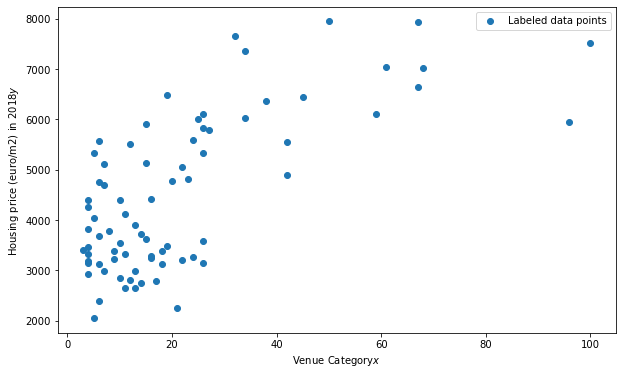

In [168]:
plt.figure(figsize=(10, 6))
plt.scatter(X, y,label="Labeled data points")
plt.ylabel('Housing price (euro/m2) in 2018' + r'$y$')
plt.xlabel('Venue Category' + r'$x$')
plt.legend()
plt.show()

This scatter figure shows the potential regression relationship. Let's try first with linerRegression

In [169]:
# First, we need to reshape X vector to fit our analyse later.
X = X.reshape(-1,1)
X.shape

(76, 1)

Here, we try several regression methods to find the models

In [170]:
reg = LinearRegression(fit_intercept=True)
reg.fit(X, y)

LinearRegression()

In [171]:
x_sorted = np.sort(X)

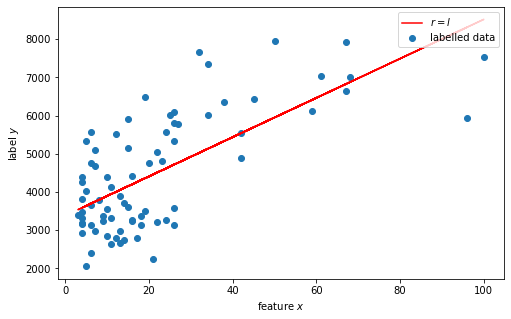

In [172]:
# Plot the dataset and predictor functions
plt.figure(figsize=(8,5))
plt.scatter(X, y,label="labelled data")

plt.plot(x_sorted, reg.predict(x_sorted), color = 'red', label="$r=l$")

plt.ylabel('label ' + r'$y$')
plt.xlabel('feature ' + r'$x$')
plt.legend(loc='upper right')
plt.show()

In [173]:
print(lin_reg.coef_, lin_reg.intercept_)

[51.35014415] 3384.874524714829


Thus, for the linerRegression, we have the relationship as follows:

In [174]:
y_lin = 51.35014415*X + 3384.874524714829

### 4.2 Non-linear Regression

From an initial look at the plot, we determine to also try non-linear Regrssion, which is Logarithmic function. Looks could be a good approximation, since it has the property of starting with a fast growth first and then more like flat increase later. 

In [175]:
np.polyfit(np.log(X.ravel()), y, 1)

array([1140.74705299, 1412.59844961])

Thus, for the Logarithmic function, we have the relationship as follows:

In [176]:
x = X.ravel()
x_sorted_2 = np.sort(x)
print(x_sorted_2)

[  3   4   4   4   4   4   4   4   4   5   5   5   6   6   6   6   6   7
   7   7   8   9   9  10  10  10  11  11  11  12  12  13  13  13  14  14
  15  15  15  16  16  16  17  18  18  19  19  20  21  22  22  23  24  24
  25  26  26  26  26  26  27  32  34  34  38  42  42  45  50  59  61  67
  67  68  96 100]


In [177]:
yy = 1140.74705299*(np.log(x_sorted_2)) + 1412.59844961

In [178]:
yy

array([2665.83718029, 2994.00965663, 2994.00965663, 2994.00965663,
       2994.00965663, 2994.00965663, 2994.00965663, 2994.00965663,
       2994.00965663, 3248.56000519, 3248.56000519, 3248.56000519,
       3456.5427838 , 3456.5427838 , 3456.5427838 , 3456.5427838 ,
       3456.5427838 , 3632.38971753, 3632.38971753, 3632.38971753,
       3784.71526015, 3919.07591096, 3919.07591096, 4039.2656087 ,
       4039.2656087 , 4039.2656087 , 4147.99041543, 4147.99041543,
       4147.99041543, 4247.24838731, 4247.24838731, 4338.5568702 ,
       4338.5568702 , 4338.5568702 , 4423.09532104, 4423.09532104,
       4501.79873587, 4501.79873587, 4501.79873587, 4575.42086366,
       4575.42086366, 4575.42086366, 4644.57822233, 4709.78151448,
       4709.78151448, 4771.4585378 , 4771.4585378 , 4829.97121221,
       4885.6284482 , 4938.69601895, 4938.69601895, 4989.4042361 ,
       5037.95399082, 5037.95399082, 5084.52156077, 5129.26247371,
       5129.26247371, 5129.26247371, 5129.26247371, 5129.26247

Let's also plot the figure out

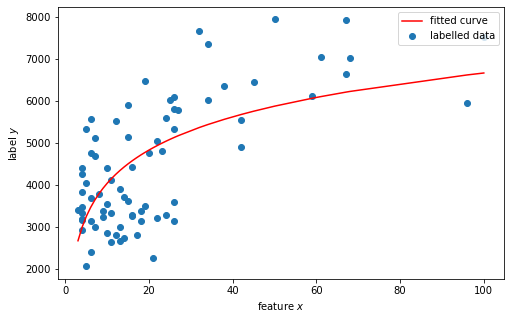

In [180]:
plt.figure(figsize=(8,5))
plt.scatter(X, y,label="labelled data")

plt.plot(x_sorted_2, yy, color = 'red', label="fitted curve")
plt.ylabel('label ' + r'$y$')
plt.xlabel('feature ' + r'$x$')
plt.legend(loc='upper right')
plt.show()

Let's evaluate both above models to choose the better one.

### 4.2 Evaluation

Let's ouput both R2-scores from above models. 

In [184]:
yy_pred = 1140.74705299*(np.log(x_sorted_2)) + 1412.59844961

In [186]:
print("Logarithmic function: R2-score: %.2f" % r2_score(y , yy_pred) )
print("Linear Regrssion: R2-score: %.2f" % r2_score(y , reg.predict(X)) )

Logarithmic function: R2-score: -0.18
Linear Regrssion: R2-score: 0.47


Both models are not very suitable for the prediction. But linear Regression is obvisouly has much better prediction than  Logarithmic function. Further studies can be done using PolynomialFeatures. 

## 5. Results and Discussion 

This project shows the initial relationship between the housing price and maturity index of different districts. Generall speaking, if more different venues in this aera, the housing price in this area would be higher than others.

Linear Regression give us a R2 score about 0.47, it is not strong, but still related. The possible reasons could be as follows:

- When obtained the venues number, we have limited the number to 100, and radius to 500, but the area radius could be larger than 500 meters. and some areas have obviously more than 100 venues. 

- We sum up all different categories together to indicate the maturity index. We could in the further study, separately calcaute the numbers of different categories(says Foursquare has 9 root categories, we can count the number for each category, then we have 9 different features), with more acurate features, the 'weights' that contribute to the housing price can be also obtained.

Thus, we can improve this model in the furture from those 2 aspects.

But generally, we can say that the maturity index from one district has relationship with its housing price.

## 6. Conclusion

Purpose of this project was to check the relationship between housing price and maturity index of different postal districts in Helsinki. Final decission on relationship is around 0.5 related, but the analyse can be improved by the discussion above.